In [91]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input

# Data Generator

In [93]:
# Read in train/valid ids:
train_ids_path = "/home/jtabalon/airway_seg/train_ids.txt"
valid_ids_path = "/home/jtabalon/airway_seg/valid_ids.txt"

with open(train_ids_path, "r") as file:
    train_ids = [line.rstrip() for line in file]

with open(valid_ids_path, "r") as file:
    valid_ids = [line.rstrip() for line in file]

print(len(train_ids), len(valid_ids))


206 26


In [94]:
# TODO: configure number of pixels in a given slice as a hyper parameter.
# TODO: configure number of patches per image as hyper parameter.


def data_generator(ids, data_dir, batch_size=1, patch_size=64, shuffle=True):
    while True:
        # Set seed
        # np.random.seed(42)   

        # if shuffle:
        #     np.random.shuffle(ids)
        # num_batches = len(id) / batch_size

        patch_distance = int(patch_size / 2)

        for patient_id in ids:
            # Read in image

            img_dir = data_dir + "/ct/ct_patients" + str(patient_id) + ".nii"
            mask_dir = data_dir + "/labels/aw_" + str(patient_id) + ".nii"

            img = nib.load(img_dir).get_fdata() / 2000.
            mask = nib.load(mask_dir).get_fdata()

            row_dim = img.shape[0]
            column_dim = img.shape[1]
            slice_dim = img.shape[2]

            # Define mask to randomly find patch midpoint within bounds of patch distance
            working_mask = mask[patch_distance:(row_dim-patch_distance), \
                            patch_distance:(column_dim-patch_distance), \
                            patch_distance:(slice_dim-patch_distance)]

            # Iterate through slices
            slices = np.sum(working_mask, axis=(0,1))

            # Find slices which contain mask
            slices_with_airway = [i for i in range(0, len(slices)) if slices[i] > 0] # Potentially tune this 0 hyper parameter

            # Randomly find slice
            random_slice_index = np.random.randint(0, len(slices_with_airway)) # in small 3d... 
            random_slice = slices_with_airway[random_slice_index]

            # Find columns which contain mask
            row_column_locations = np.where(working_mask[:,:,random_slice] > 0)
            num_mask_voxels = len(row_column_locations[0]) 

            # Randomly find row + column
            random_row_column_index = np.random.randint(0, num_mask_voxels)
            random_row = row_column_locations[0][random_row_column_index]
            random_column = row_column_locations[1][random_row_column_index]

            # Adjust voxel coordinates for larger image
            adjusted_row = random_row + patch_distance
            adjusted_column = random_column + patch_distance
            adjusted_slice = random_slice + patch_distance

            # Final voxel coordinates       
            voxel_coordinates = (adjusted_row, adjusted_column, adjusted_slice)

            # Index based on specified patch distance
            indexed_patch_img = img[(adjusted_row-patch_distance):(adjusted_row+patch_distance), \
                    (adjusted_column-patch_distance):(adjusted_column+patch_distance), \
                    (adjusted_slice-patch_distance):(adjusted_slice+patch_distance)]

            indexed_patch_label = mask[(adjusted_row-patch_distance):(adjusted_row+patch_distance), \
                            (adjusted_column-patch_distance):(adjusted_column+patch_distance), \
                            (adjusted_slice-patch_distance):(adjusted_slice+patch_distance)]

            # Add patient and channel
            patch_img = np.expand_dims(np.expand_dims(indexed_patch_img, -1), 0)
            patch_mask = np.expand_dims(np.expand_dims(indexed_patch_label, -1), 0)

            final_patch_img = tf.convert_to_tensor(patch_img)
            final_patch_mask = tf.convert_to_tensor(patch_mask)

            yield (final_patch_img, final_patch_mask)

# Model Creation

In [95]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

In [96]:
# Hyperparameter Tuning
batch_size = 1  
learning_rate = 1e-5 # TODO: 1e-4: stuck at local minima... try with more data?

In [97]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
    print(pool4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    return model

In [98]:
# We'll leave the default branch of the git repo as a dice_loss for now until we get actually training.
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

In [99]:
def compile_model(learning_rate):
    model.compile(optimizer = Adam(lr=learning_rate), loss = dice_loss)

In [100]:
model = unet(input_size=(64,64,64, 1))
compile_model(learning_rate)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32, 64), dtype=tf.float32, name=None), name='max_pooling3d_12/MaxPool3D:0', description="created by layer 'max_pooling3d_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 16, 128), dtype=tf.float32, name=None), name='max_pooling3d_13/MaxPool3D:0', description="created by layer 'max_pooling3d_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 8, 256), dtype=tf.float32, name=None), name='max_pooling3d_14/MaxPool3D:0', description="created by layer 'max_pooling3d_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 4, 512), dtype=tf.float32, name=None), name='max_pooling3d_15/MaxPool3D:0', description="created by layer 'max_pooling3d_15'")


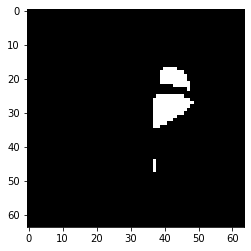

In [101]:
plt.imshow(final_patch_mask[0,:,:,52,0] , cmap = "gray")

In [102]:
train_dir = "/home/jtabalon/airway_seg_data/train"
valid_dir = "/home/jtabalon/airway_seg_data/valid"

In [104]:
# TODO: Fix valid_generator.
training_generator = data_generator(ids=train_ids, data_dir=train_dir, batch_size=1, patch_size=64)
valid_generator = data_generator(ids=valid_ids, data_dir=valid_dir, batch_size=1, patch_size=64)

In [105]:
checkpoint_filepath = "/home/jtabalon/ckpt_airway_seg"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor="loss",
    # monitor="val_loss"
)

In [106]:
# TODO: fix validation loop.

model.fit(x=training_generator, \
#      validation_data=valid_generator, \
#      validation_batch_size=2, \
#      validation_freq=5, \
      steps_per_epoch = len(train_ids) // batch_size, \
      epochs=1000, \
      callbacks=[model_checkpoint_callback])

Epoch 1/1000
107/206 [==============>...............] - ETA: 2:19 - loss: 0.9018

KeyboardInterrupt: 

In [ ]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata() / 2000.
mask = nib.load(aw_path).get_fdata()

test_img = np.expand_dims(np.expand_dims(img, -1), 0)
test_mask = np.expand_dims(np.expand_dims(mask, -1), 0)

In [ ]:
# TODO configure prediction section
#prediction = model.predict(test_img)

In [ ]:
# np.argmax(np.sum(prediction[0,:,:,:,0]))

0

In [ ]:
# For visualizing distribution of mask
# plt.hist(img_change.flatten())
# plt.hist(label_change.flatten())

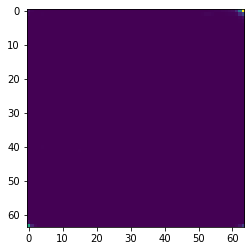

In [ ]:
# plt.imshow(prediction[0,:,:,0,0])

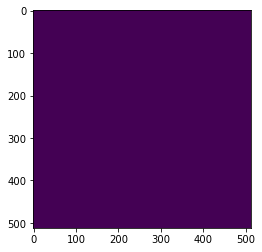

In [ ]:
# plt.imshow(test_mask[0,:,:,32,0])